Using dataset at: /Users/jinsyl/ML Class/drug_disintegration_ml/data/raw/final_data_all_excipients.csv

🔹 Stacked Model – RMSE: 23.82, R²: 0.688
Saved stacked model to: models/stacked_lgbm_rf_model.joblib


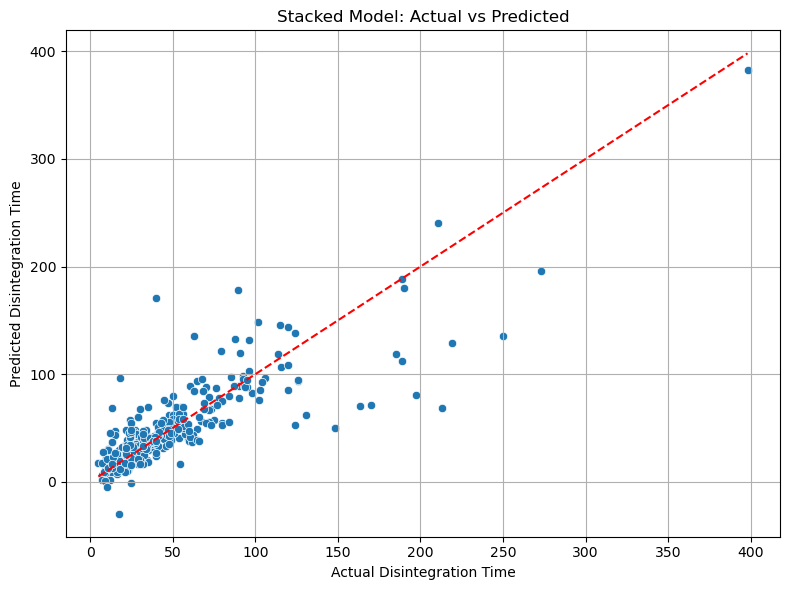

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge

import lightgbm as lgb

# 📂 1. Load Dataset
file_path = "/Users/jinsyl/ML Class/drug_disintegration_ml/data/raw/final_data_all_excipients.csv"
print("Using dataset at:", file_path)
df = pd.read_csv(file_path)

# ⚙️ 2. Define Features & Target
X = df.drop(columns=['DISINTEGRATION_TIME'])
y = df['DISINTEGRATION_TIME']

# 🧪 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔨 4. Define base models
rf = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_leaf=3, random_state=42)
lgbm = lgb.LGBMRegressor(verbosity = -1, n_estimators=300, max_depth=20, learning_rate=0.05, random_state=42)

# 🔗 5. Create stacking model
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('lgbm', lgbm)
    ],
    final_estimator=Ridge(alpha=1.0),
    passthrough=True
)

# 🧱 6. Build pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('stacked', stacked_model)
])

# 🚀 7. Fit the model
pipeline.fit(X_train, y_train)

# 📊 8. Evaluate
y_pred = pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"\n🔹 Stacked Model – RMSE: {rmse:.2f}, R²: {r2:.3f}")

# 💾 9. Save the model
model_path = "models/stacked_lgbm_rf_model.joblib"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(pipeline, model_path)
print(f"Saved stacked model to: {model_path}")

# 📈 10. Plot predictions vs true values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Disintegration Time")
plt.ylabel("Predicted Disintegration Time")
plt.title("Stacked Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig("models/stacked_model_plot.png")
plt.show()


Using dataset at: /Users/jinsyl/ML Class/drug_disintegration_ml/data/raw/final_data_all_excipients.csv

✅ Boosted Stacked Model – RMSE: 23.48, R²: 0.697
Saved model to: models/boosted_stacked_model.joblib


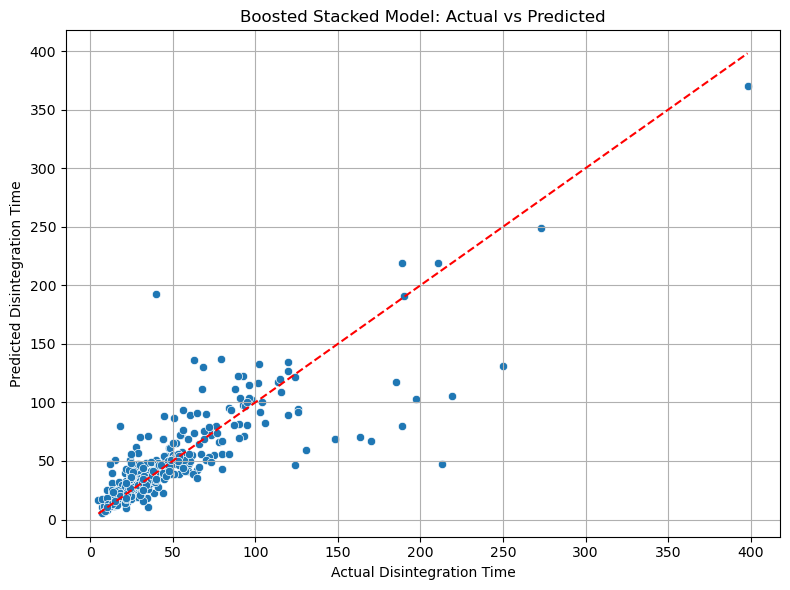

In [4]:
#Stacked Boosted

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# 📂 Load Dataset
file_path = "/Users/jinsyl/ML Class/drug_disintegration_ml/data/raw/final_data_all_excipients.csv"
print("Using dataset at:", file_path)
df = pd.read_csv(file_path)

# ⚙️ Split features and target
X = df.drop(columns=['DISINTEGRATION_TIME'])
y = df['DISINTEGRATION_TIME']

# 📉 Remove low-variance features
low_variance_cols = X.columns[X.nunique() <= 1]
X.drop(columns=low_variance_cols, inplace=True)

# 🔍 Log-transform skewed numeric features
numeric_cols = X.select_dtypes(include=[np.number]).columns
skewed = X[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_features = skewed[skewed > 1].index
X[skewed_features] = np.log1p(X[skewed_features])

# 🧪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔨 Define base models
rf = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_leaf=3, random_state=42)
lgbm = lgb.LGBMRegressor(
    verbosity = -1,
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=64,
    max_depth=10,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    force_col_wise=True,
    random_state=42,
    n_jobs=-1
)

# Final estimator
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 🔗 Stacking model
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('lgbm', lgbm)
    ],
    final_estimator=xgb,
    passthrough=True,
    cv=5
)

# 🧱 Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('stacked', stacked_model)
])

# 🚀 Train
pipeline.fit(X_train, y_train)

# 📊 Evaluate
y_pred = pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"\n✅ Boosted Stacked Model – RMSE: {rmse:.2f}, R²: {r2:.3f}")

# 💾 Save model
model_path = "models/boosted_stacked_model.joblib"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(pipeline, model_path)
print(f"Saved model to: {model_path}")

# 📈 Plot predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Disintegration Time")
plt.ylabel("Predicted Disintegration Time")
plt.title("Boosted Stacked Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig("models/boosted_stacked_model_plot.png")
plt.show()
